# Nipype Showcase

What's all the hype about Nipype? Is it really that good? Short answer: Yes!

Long answer: ... well, let's consider a very simple fMRI preprocessing workflow that just performs:
1. slice time correction
2. motion correction
3. smoothing

# Preparing the preprocessing workflow

First, we need to import the main Nipype tools: `Node` and `Workflow`

In [1]:
from nipype import Node, Workflow

191023-11:24:43,583 nipype.utils INFO:
	 Running nipype version 1.2.3 (latest: 1.2.3)


Now, we can import the interfaces that we want to use for the preprocessing.

In [2]:
from nipype.interfaces.fsl import SliceTimer, MCFLIRT, Smooth

Next, we will put the three interfaces into a node and define the specific input parameters.

In [3]:
# Initiate a node to correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             time_repetition=2.5),
                  name="slicetimer")

191023-11:24:43,807 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [4]:
# Initiate a node to correct for motion
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

191023-11:24:43,814 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [5]:
# Initiate a node to smooth functional images
smooth = Node(Smooth(fwhm=4), name="smooth")

191023-11:24:43,821 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


After creating the nodes, we can now create the preprocessing workflow.

In [6]:
preproc01 = Workflow(name='preproc01', base_dir='.')

Now, we can put all the nodes into this preprocessing workflow. We specify the data flow / execution flow of the workflow by connecting the corresponding nodes to each other.

In [7]:
preproc01.connect([(slicetimer, mcflirt, [('slice_time_corrected_file', 'in_file')]),
                   (mcflirt, smooth, [('out_file', 'in_file')])])

To better understand what we did we can write out the workflow graph and visualize it directly in this notebook.

In [8]:
preproc01.write_graph(graph2use='orig')

191023-11:24:44,674 nipype.workflow INFO:
	 Generated workflow graph: /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/graph.png (graph2use=orig, simple_form=True).


'/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/graph.png'

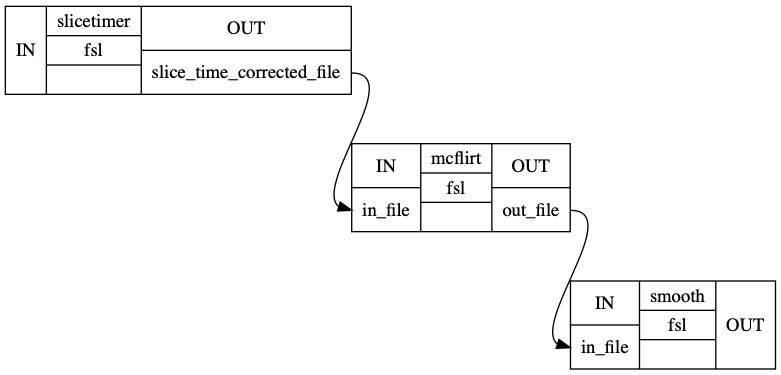

In [9]:
# Visualize graph
from IPython.display import Image
Image(filename="preproc01/graph_detailed.png")

# Run the workflow on one functional image

Now, that we've created a workflow, let's run it on a functional image.

For this, we first need to specify the input file of the very first node, i.e. the `slicetimer` node.

In [10]:
slicetimer.inputs.in_file = '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz'

To show off Nipype's parallelization power, let's run the workflow in parallel, on 5 processors and let's show the execution time:

In [11]:
%time preproc01.run('MultiProc', plugin_args={'n_procs': 5})

191023-11:24:44,736 nipype.workflow INFO:
	 Workflow preproc01 settings: ['check', 'execution', 'logging', 'monitoring']
191023-11:24:44,743 nipype.workflow INFO:
	 Running in parallel.
191023-11:24:44,750 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 5/5.
191023-11:24:44,816 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.slicetimer" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/slicetimer".
191023-11:24:44,829 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz --odd --out=/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/slicetimer/sub-01_ses-test_task-fingerfootlips_bold_st.nii --repeat=2.500000
191023-11:24:44,837 ni

RuntimeError: Workflow did not execute cleanly. Check log for details

## Conclusion

Nice, the whole execution took ~2min. But wait... The parallelization didn't really help.

That's true, but because there was no possibility to run the workflow in parallel. Each node depends on the output of the previous node.

# Results of `preproc01`

So, what did we get? Let's look at the output folder `preproc01`:

In [12]:
!tree preproc01 -I '*js|*json|*pklz|_report|*.dot|*html'

/bin/sh: tree: command not found


# Rerunning of a workflow

Now, for fun. Let's run the workflow again, but let's change the `fwhm` value of the Gaussian smoothing kernel to `2`.

In [13]:
smooth.inputs.fwhm = 2

And let's run the workflow again.

In [14]:
%time preproc01.run('MultiProc', plugin_args={'n_procs': 5})

191023-11:24:49,101 nipype.workflow INFO:
	 Workflow preproc01 settings: ['check', 'execution', 'logging', 'monitoring']
191023-11:24:49,108 nipype.workflow INFO:
	 Running in parallel.
191023-11:24:49,112 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 5/5.
191023-11:24:49,197 nipype.workflow INFO:
	 [Node] Setting-up "preproc01.slicetimer" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/slicetimer".
191023-11:24:49,209 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz --odd --out=/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/preproc01/slicetimer/sub-01_ses-test_task-fingerfootlips_bold_st.nii --repeat=2.500000
191023-11:24:49,217 ni

RuntimeError: Workflow did not execute cleanly. Check log for details

## Conclusion

Interesting, now it only took ~15s to execute the whole workflow again. **What happened?**

As you can see from the log above, Nipype didn't execute the two nodes `slicetimer` and `mclfirt` again. This, because their input values didn't change from the last execution. The `preproc01` workflow therefore only had to rerun the node `smooth`.

# Running a workflow in parallel

Ok, ok... Rerunning a workflow again is faster. That's nice and all, but I want more. **You spoke of parallel execution!**

We saw that the `preproc01` workflow takes about ~2min to execute completely. So, if we would run the workflow on five functional images, it should take about ~10min total. This, of course, assuming the execution will be done sequentially. Now, let's see how long it takes if we run it in parallel.

In [15]:
# First, let's copy/clone 'preproc01'
preproc02 = preproc01.clone('preproc02')
preproc03 = preproc01.clone('preproc03')
preproc04 = preproc01.clone('preproc04')
preproc05 = preproc01.clone('preproc05')

We now have five different preprocessing workflows. If we want to run them in parallel, we can put them all in another workflow.

In [16]:
metaflow = Workflow(name='metaflow', base_dir='.')

In [17]:
# Now we can add the five preproc workflows to the bigger metaflow
metaflow.add_nodes([preproc01, preproc02, preproc03,
                    preproc04, preproc05])

**Note:** We now have a workflow (`metaflow`), that contains five other workflows (`preproc0?`), each of them containing three nodes.

To better understand this, let's visualize this `metaflow`.

In [18]:
# As before, let's write the graph of the workflow
metaflow.write_graph(graph2use='flat')

191023-11:24:53,510 nipype.workflow INFO:
	 Generated workflow graph: /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/metaflow/graph.png (graph2use=flat, simple_form=True).


'/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/metaflow/graph.png'

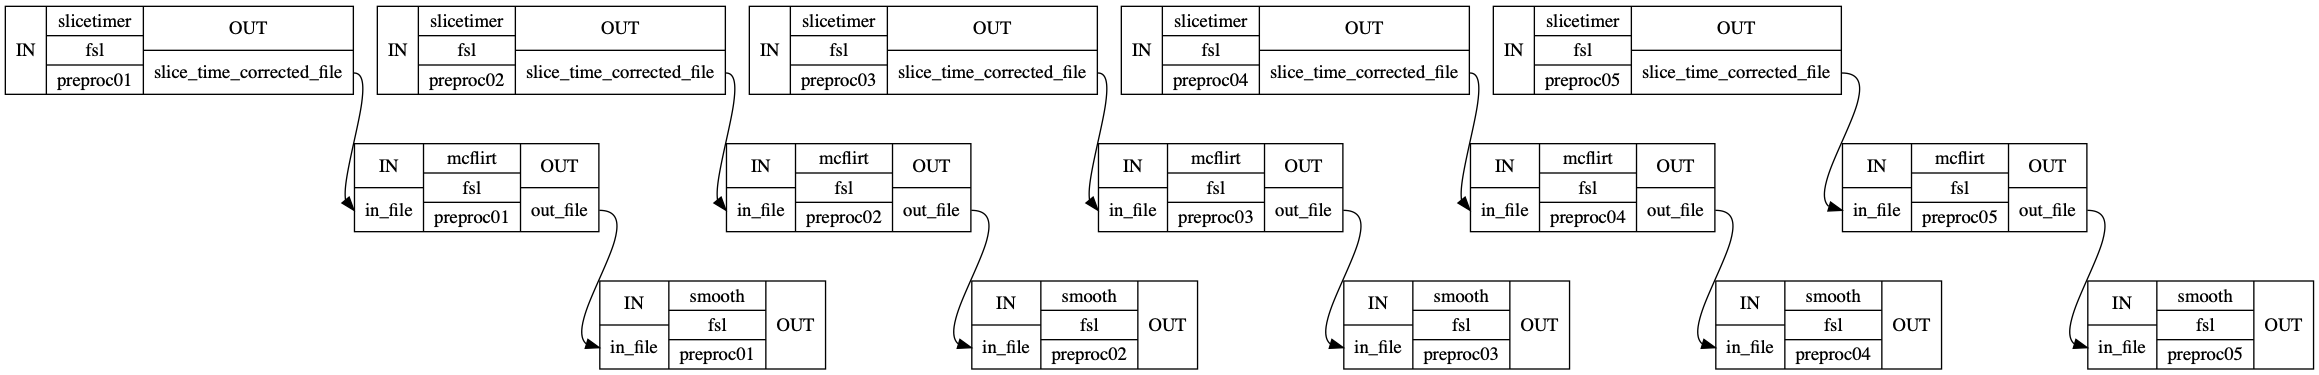

In [19]:
# And visualize the graph
from IPython.display import Image
Image(filename="metaflow/graph_detailed.png")

Ah... so now we can see that the `metaflow` has potential for parallelization. So let's put it to test

In [20]:
%time metaflow.run('MultiProc', plugin_args={'n_procs': 5})

191023-11:24:53,557 nipype.workflow INFO:
	 Workflow metaflow settings: ['check', 'execution', 'logging', 'monitoring']
191023-11:24:53,569 nipype.workflow INFO:
	 Running in parallel.
191023-11:24:53,572 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 5/5.
191023-11:24:53,645 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc01.slicetimer" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/metaflow/preproc01/slicetimer".
191023-11:24:53,649 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc02.slicetimer" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/metaflow/preproc02/slicetimer".
191023-11:24:53,651 nipype.workflow INFO:
	 [Node] Setting-up "metaflow.preproc03.slicetimer" in "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/metaflow/preproc03/slicetimer".
191023-11:24:5

191023-11:24:55,592 nipype.workflow ERROR:
	 Node slicetimer failed to run on host calcium.mbi.monash.edu.au.
191023-11:24:55,594 nipype.workflow ERROR:
	 Saving crash info to /Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/workshop-notebook/notebooks/crash-20191023-112455-tclose-slicetimer-4ae5f019-f686-4788-a6c4-7e6b4d0e92c3.pklz
Traceback (most recent call last):
  File "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/venv/lib/python3.7/site-packages/nipype/pipeline/plugins/multiproc.py", line 69, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/venv/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 479, in run
    result = self._run_interface(execute=True)
  File "/Users/tclose/Documents/Workshops/2019-11-15-N.A.B.-workshop/venv/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 569, in _run_interface
    return self._run_command(execute)

RuntimeError: Workflow did not execute cleanly. Check log for details

This time we can see that Nipype uses all available processors.

And if all went well, the total execution time should still be around ~2min.

That's why Nipype is so amazing. The days of opening multiple SPMs, FSLs, AFNIs etc. are past!

# Results of `metaflow`

In [21]:
!tree metaflow -I '*js|*json|*pklz|_report|*.dot|*html'

/bin/sh: tree: command not found
